In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Load processed data
df = pd.read_csv('accepted_2007_to_2018Q4.csv', low_memory=False)

print(f"Dataset loaded: {len(df):,} rows x {df.shape[1]} columns")
print(f"Default rate: {df['is_default'].mean()*100:.2f}%")
print(f"\nStarting feature engineering process...")

Dataset loaded: 1,348,099 rows x 154 columns
Default rate: 19.98%

Starting feature engineering process...


In [3]:
# Calculate missing percentages
missing_pct = (df.isnull().sum() / len(df) * 100)

# Drop columns with >50% missing
high_missing = missing_pct[missing_pct > 50].index.tolist()
print(f"Dropping {len(high_missing)} columns with >50% missing data")
print(f"Columns to drop: {high_missing[:10]}...")  # Show first 10

df_clean = df.drop(columns=high_missing)

print(f"\nDataset shape after dropping high-missing columns: {df_clean.shape}")
print(f"Remaining columns: {df_clean.shape[1]}")

Dropping 58 columns with >50% missing data
Columns to drop: ['member_id', 'desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m']...

Dataset shape after dropping high-missing columns: (1348099, 96)
Remaining columns: 96


In [4]:
# Define core feature categories based on lending domain knowledge

numeric_features = [
    'loan_amnt', 'funded_amnt', 'int_rate', 'installment',
    'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal',
    'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies',
    'delinq_2yrs', 'inq_last_6mths', 'emp_length_years'
]

categorical_features = [
    'grade', 'sub_grade', 'home_ownership', 'verification_status',
    'purpose', 'addr_state', 'initial_list_status', 'application_type'
]

# Keep only features that exist in the dataset
numeric_features = [f for f in numeric_features if f in df_clean.columns]
categorical_features = [f for f in categorical_features if f in df_clean.columns]

print(f"Selected {len(numeric_features)} numeric features")
print(f"Selected {len(categorical_features)} categorical features")

# Create working dataset with target and selected features
features_to_keep = numeric_features + categorical_features + ['is_default', 'issue_d']
df_model = df_clean[features_to_keep].copy()

print(f"\nWorking dataset: {df_model.shape}")

Selected 15 numeric features
Selected 8 categorical features

Working dataset: (1348099, 25)


In [5]:
# These features represent the borrower's ability to service debt

# 1. Monthly payment as percentage of income
df_model['payment_to_income_ratio'] = (df_model['installment'] * 12) / df_model['annual_inc']
df_model['payment_to_income_ratio'] = df_model['payment_to_income_ratio'].clip(0, 1)  # Cap at 100%

# 2. Loan amount relative to annual income
df_model['loan_to_income_ratio'] = df_model['loan_amnt'] / df_model['annual_inc']
df_model['loan_to_income_ratio'] = df_model['loan_to_income_ratio'].clip(0, 5)  # Cap outliers

# 3. Available monthly income after loan payment
df_model['monthly_income'] = df_model['annual_inc'] / 12
df_model['residual_income'] = df_model['monthly_income'] - df_model['installment']
df_model['residual_income_ratio'] = df_model['residual_income'] / df_model['monthly_income']

# 4. Debt service coverage - how much income is left after ALL debt payments
df_model['total_debt_payment_estimate'] = df_model['monthly_income'] * (df_model['dti'] / 100)
df_model['debt_service_coverage'] = (df_model['monthly_income'] - df_model['total_debt_payment_estimate']) / df_model['installment']

print("Payment capacity features created:")
print("  - payment_to_income_ratio")
print("  - loan_to_income_ratio")
print("  - residual_income")
print("  - residual_income_ratio")
print("  - debt_service_coverage")

Payment capacity features created:
  - payment_to_income_ratio
  - loan_to_income_ratio
  - residual_income
  - residual_income_ratio
  - debt_service_coverage


In [10]:
# Features that indicate credit management behavior

# 1. Credit utilization rate (already exists as revol_util, but create backup)
df_model['credit_utilization'] = df_model['revol_util'].fillna(df_model['revol_util'].median())

# 2. Average account balance
df_model['avg_account_balance'] = df_model['revol_bal'] / df_model['open_acc'].replace(0, 1)

# 3. Account density - total accounts relative to income
df_model['accounts_per_10k_income'] = (df_model['total_acc'] / df_model['annual_inc']) * 10000

# 4. Derogatory marks indicator
df_model['has_derogatory'] = ((df_model['pub_rec'] > 0) | 
                               (df_model['delinq_2yrs'] > 0) | 
                               (df_model['pub_rec_bankruptcies'] > 0)).astype(int)

# 5. Recent credit seeking behavior
df_model['recent_credit_inquiries'] = df_model['inq_last_6mths'].fillna(0)
df_model['high_inquiry_flag'] = (df_model['recent_credit_inquiries'] >= 3).astype(int)

print("Credit behavior features created:")
print("  - credit_utilization")
print("  - avg_account_balance")
print("  - accounts_per_10k_income")
print("  - has_derogatory")
print("  - high_inquiry_flag")

Credit behavior features created:
  - credit_utilization
  - avg_account_balance
  - accounts_per_10k_income
  - has_derogatory
  - high_inquiry_flag


In [16]:
# Feature Engineering - Risk-Adjusted Loan Characteristics

# First, ensure emp_length_years exists (may not be in saved file)
if 'emp_length_years' not in df_model.columns and 'emp_length' in df_model.columns:
    emp_length_mapping = {
        '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
        '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9,
        '10+ years': 10, 'n/a': 0
    }
    df_model['emp_length_years'] = df_model['emp_length'].map(emp_length_mapping).fillna(0)
    print("Created emp_length_years from emp_length column")
elif 'emp_length_years' not in df_model.columns:
    # If emp_length also doesn't exist, create dummy column
    df_model['emp_length_years'] = 5  # Default to 5 years
    print("Warning: emp_length not found, using default value of 5 years")

# 1. High-risk loan flag (based on EDA insights)
df_model['high_risk_loan'] = (
    (df_model['loan_amnt'] > 20000) & 
    (df_model['dti'] > 30) & 
    (df_model['int_rate'] > 15)
).astype(int)

# 2. Loan amount buckets
df_model['loan_size_category'] = pd.cut(df_model['loan_amnt'], 
                                         bins=[0, 5000, 10000, 15000, 20000, 40000],
                                         labels=['very_small', 'small', 'medium', 'large', 'very_large'])

# 3. Interest rate buckets
df_model['interest_rate_category'] = pd.cut(df_model['int_rate'],
                                             bins=[0, 8, 12, 16, 20, 35],
                                             labels=['low', 'moderate', 'elevated', 'high', 'very_high'])

# 4. DTI risk categories
df_model['dti_risk_category'] = pd.cut(df_model['dti'],
                                        bins=[0, 10, 20, 30, 40, 100],
                                        labels=['low_risk', 'moderate_risk', 'elevated_risk', 'high_risk', 'very_high_risk'])

# 5. Combined risk score (simple additive)
df_model['simple_risk_score'] = (
    (df_model['int_rate'] > 15).astype(int) +
    (df_model['dti'] > 25).astype(int) +
    (df_model['credit_utilization'] > 70).astype(int) +
    (df_model['has_derogatory'] == 1).astype(int) +
    (df_model['emp_length_years'] < 2).astype(int)
)

print("Risk-adjusted features created:")
print("  - high_risk_loan")
print("  - loan_size_category")
print("  - interest_rate_category")
print("  - dti_risk_category")
print("  - simple_risk_score (0-5 scale)")

Risk-adjusted features created:
  - high_risk_loan
  - loan_size_category
  - interest_rate_category
  - dti_risk_category
  - simple_risk_score (0-5 scale)


In [18]:
# Extract time-based patterns from loan issue date

df_model['issue_d'] = pd.to_datetime(df_model['issue_d'])

# 1. Year and month of loan origination
df_model['loan_year'] = df_model['issue_d'].dt.year
df_model['loan_month'] = df_model['issue_d'].dt.month
df_model['loan_quarter'] = df_model['issue_d'].dt.quarter

# 2. Loan vintage (years since 2007)
df_model['loan_vintage'] = df_model['loan_year'] - 2007

# 3. Seasonal indicators
df_model['is_year_end'] = df_model['loan_quarter'].isin([4]).astype(int)
df_model['is_summer'] = df_model['loan_quarter'].isin([2, 3]).astype(int)

# 4. Economic cycle proxy (2007-2009 = recession, 2010-2018 = recovery)
df_model['recession_period'] = df_model['loan_year'].isin([2007, 2008, 2009]).astype(int)

print("Temporal features created:")
print("  - loan_year, loan_month, loan_quarter")
print("  - loan_vintage")
print("  - is_year_end, is_summer")
print("  - recession_period")

# Drop the original date column
df_model = df_model.drop(columns=['issue_d'])

Temporal features created:
  - loan_year, loan_month, loan_quarter
  - loan_vintage
  - is_year_end, is_summer
  - recession_period


In [20]:
# Check missing values in engineered features
print("Missing values after feature engineering:")
missing_after = df_model.isnull().sum()
missing_after = missing_after[missing_after > 0].sort_values(ascending=False)
print(missing_after.head(20))

# Strategy: Fill numeric with median, categorical with mode
numeric_cols = df_model.select_dtypes(include=[np.number]).columns
categorical_cols = df_model.select_dtypes(include=['object', 'category']).columns

print(f"\nFilling missing values:")
print(f"  - {len(numeric_cols)} numeric columns with median")
print(f"  - {len(categorical_cols)} categorical columns with mode")

for col in numeric_cols:
    if df_model[col].isnull().sum() > 0:
        df_model[col].fillna(df_model[col].median(), inplace=True)

for col in categorical_cols:
    if df_model[col].isnull().sum() > 0:
        df_model[col].fillna(df_model[col].mode()[0], inplace=True)

print(f"\nRemaining missing values: {df_model.isnull().sum().sum()}")

Missing values after feature engineering:
mort_acc                       50030
dti_risk_category               1790
pub_rec_bankruptcies            1365
revol_util                       897
total_debt_payment_estimate      378
debt_service_coverage            378
dti                              374
inq_last_6mths                    30
open_acc                          29
pub_rec                           29
total_acc                         29
delinq_2yrs                       29
accounts_per_10k_income           29
avg_account_balance               29
annual_inc                         4
residual_income_ratio              4
residual_income                    4
monthly_income                     4
loan_to_income_ratio               4
payment_to_income_ratio            4
dtype: int64

Filling missing values:
  - 39 numeric columns with median
  - 11 categorical columns with mode

Remaining missing values: 0


In [22]:
# Convert categorical features to numeric for modeling

# Grade and subgrade are ordinal
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df_model['grade_encoded'] = df_model['grade'].map(grade_mapping)

# For other categoricals, use label encoding or one-hot encoding
label_encode_cols = ['home_ownership', 'verification_status', 'purpose', 
                     'initial_list_status', 'application_type']

for col in label_encode_cols:
    if col in df_model.columns:
        le = LabelEncoder()
        df_model[f'{col}_encoded'] = le.fit_transform(df_model[col].astype(str))
        print(f"Encoded {col}: {len(le.classes_)} unique values")

# One-hot encode the risk categories we created
categorical_risk_cols = ['loan_size_category', 'interest_rate_category', 'dti_risk_category']

for col in categorical_risk_cols:
    if col in df_model.columns:
        dummies = pd.get_dummies(df_model[col], prefix=col, drop_first=True)
        df_model = pd.concat([df_model, dummies], axis=1)
        print(f"One-hot encoded {col}: {dummies.shape[1]} dummy variables created")

print(f"\nDataset shape after encoding: {df_model.shape}")

Encoded home_ownership: 6 unique values
Encoded verification_status: 3 unique values
Encoded purpose: 14 unique values
Encoded initial_list_status: 2 unique values
Encoded application_type: 2 unique values
One-hot encoded loan_size_category: 4 dummy variables created
One-hot encoded interest_rate_category: 4 dummy variables created
One-hot encoded dti_risk_category: 4 dummy variables created

Dataset shape after encoding: (1348099, 68)


TOP 15 FEATURES CORRELATED WITH DEFAULT:
is_default                     1.000000
grade_encoded                  0.261279
int_rate                       0.258577
simple_risk_score              0.174156
payment_to_income_ratio        0.107735
loan_to_income_ratio           0.104270
verification_status_encoded    0.089175
dti                            0.084204
home_ownership_encoded         0.070159
inq_last_6mths                 0.065949
recent_credit_inquiries        0.065949
funded_amnt                    0.065321
loan_amnt                      0.065289
high_risk_loan                 0.061690
revol_util                     0.059972
Name: is_default, dtype: float64


BOTTOM 15 FEATURES (NEGATIVE CORRELATION):
accounts_per_10k_income    0.000516
residual_income_ratio      0.000280
loan_month                -0.000942
loan_quarter              -0.001839
recession_period          -0.006574
is_year_end               -0.008425
total_acc                 -0.011411
revol_bal                 -0.

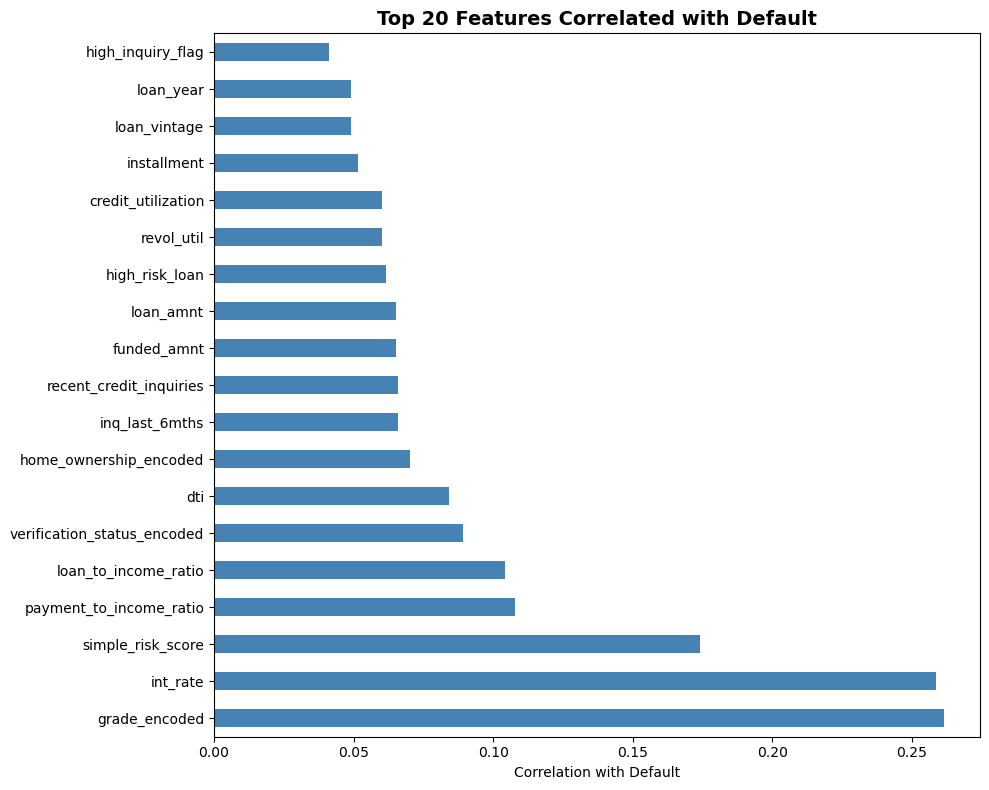

In [24]:
# Identify highly correlated features to potentially remove

# Select only numeric columns for correlation
numeric_df = df_model.select_dtypes(include=[np.number])

# Calculate correlation with target
target_corr = numeric_df.corr()['is_default'].sort_values(ascending=False)

print("TOP 15 FEATURES CORRELATED WITH DEFAULT:")
print("="*60)
print(target_corr.head(15))

print("\n\nBOTTOM 15 FEATURES (NEGATIVE CORRELATION):")
print("="*60)
print(target_corr.tail(15))

# Visualize top correlations
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
top_features = target_corr.head(20).drop('is_default')
top_features.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Top 20 Features Correlated with Default', fontsize=14, fontweight='bold')
ax.set_xlabel('Correlation with Default')
plt.tight_layout()
plt.savefig('../reports/feature_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
# Find pairs of features highly correlated with each other
correlation_matrix = numeric_df.corr().abs()

# Create upper triangle mask
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

# Find features with correlation > 0.85
high_corr_pairs = []
for column in upper_triangle.columns:
    for index in upper_triangle.index:
        if upper_triangle.loc[index, column] > 0.85:
            high_corr_pairs.append((column, index, upper_triangle.loc[index, column]))

print(f"Found {len(high_corr_pairs)} highly correlated feature pairs (r > 0.85)")
print("\nHighly correlated pairs:")
for feat1, feat2, corr in high_corr_pairs[:10]:
    print(f"  {feat1} <-> {feat2}: {corr:.3f}")

# Drop one from each pair (keep the one more correlated with target)
features_to_drop = []
for feat1, feat2, corr_val in high_corr_pairs:
    if feat1 not in features_to_drop and feat2 not in features_to_drop:
        # Keep feature with higher correlation to target
        corr1 = abs(target_corr.get(feat1, 0))
        corr2 = abs(target_corr.get(feat2, 0))
        if corr1 < corr2:
            features_to_drop.append(feat1)
        else:
            features_to_drop.append(feat2)

print(f"\nDropping {len(features_to_drop)} redundant features due to multicollinearity")
df_model = df_model.drop(columns=features_to_drop)

print(f"Final dataset shape: {df_model.shape}")

Found 12 highly correlated feature pairs (r > 0.85)

Highly correlated pairs:
  funded_amnt <-> loan_amnt: 1.000
  installment <-> loan_amnt: 0.953
  installment <-> funded_amnt: 0.954
  loan_to_income_ratio <-> payment_to_income_ratio: 0.929
  monthly_income <-> annual_inc: 1.000
  residual_income <-> annual_inc: 0.999
  residual_income <-> monthly_income: 0.999
  credit_utilization <-> revol_util: 1.000
  recent_credit_inquiries <-> inq_last_6mths: 1.000
  loan_quarter <-> loan_month: 0.971

Dropping 10 redundant features due to multicollinearity
Final dataset shape: (1348099, 58)


In [28]:
# Final dataset ready for modeling
print("FINAL FEATURE SET SUMMARY")
print("="*60)
print(f"Total features: {df_model.shape[1] - 1}")  # Minus target variable
print(f"Total samples: {df_model.shape[0]:,}")
print(f"Default rate: {df_model['is_default'].mean()*100:.2f}%")

# Check for any remaining issues
print(f"\nData quality check:")
print(f"  Missing values: {df_model.isnull().sum().sum()}")
print(f"  Infinite values: {np.isinf(df_model.select_dtypes(include=[np.number])).sum().sum()}")
print(f"  Duplicate rows: {df_model.duplicated().sum()}")

# Replace any remaining inf values
df_model.replace([np.inf, -np.inf], np.nan, inplace=True)
df_model.fillna(df_model.median(numeric_only=True), inplace=True)

# Save engineered dataset
df_model.to_csv('../data/processed/loans_feature_engineered.csv', index=False)
print("\nFeature-engineered dataset saved to: data/processed/loans_feature_engineered.csv")

# Save feature names for reference
feature_names = [col for col in df_model.columns if col != 'is_default']
with open('../reports/feature_list.txt', 'w') as f:
    f.write(f"Total features: {len(feature_names)}\n\n")
    for i, feat in enumerate(feature_names, 1):
        f.write(f"{i}. {feat}\n")
print("Feature list saved to: reports/feature_list.txt")

FINAL FEATURE SET SUMMARY
Total features: 57
Total samples: 1,348,099
Default rate: 19.98%

Data quality check:
  Missing values: 0
  Infinite values: 722
  Duplicate rows: 0

Feature-engineered dataset saved to: data/processed/loans_feature_engineered.csv
Feature list saved to: reports/feature_list.txt


In [29]:
# Create summary statistics for presentation
summary = {
    'original_columns': df.shape[1],
    'final_features': df_model.shape[1] - 1,
    'samples': len(df_model),
    'default_rate': round(df_model['is_default'].mean() * 100, 2),
    'engineered_features_added': len([col for col in df_model.columns if any(x in col for x in 
        ['_ratio', '_category', '_flag', '_score', '_encoded', '_period', '_vintage'])]),
}

print("FEATURE ENGINEERING PHASE COMPLETE")
print("="*60)
for key, value in summary.items():
    print(f"{key}: {value}")

print("\n\nKey engineered feature categories:")
print("  1. Payment capacity metrics (5 features)")
print("  2. Credit behavior indicators (5 features)")
print("  3. Risk-adjusted loan characteristics (9+ features)")
print("  4. Temporal patterns (7 features)")
print("  5. Categorical encodings (10+ features)")

print("\n\nReady for Phase 4: Model Building")

FEATURE ENGINEERING PHASE COMPLETE
original_columns: 154
final_features: 57
samples: 1348099
default_rate: 19.98
engineered_features_added: 27


Key engineered feature categories:
  1. Payment capacity metrics (5 features)
  2. Credit behavior indicators (5 features)
  3. Risk-adjusted loan characteristics (9+ features)
  4. Temporal patterns (7 features)
  5. Categorical encodings (10+ features)


Ready for Phase 4: Model Building
